In [2]:
# for installantion, uncomment and run below code
# !pip3 install -r 'requirement.txt'

In [3]:
import os
import gc
import re
import random
import string

import nltk
import numpy as np
import pandas as pd

from nltk import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

nltk.download("stopwords")

# for results reproducing
SEED = 42
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
np.random.seed(SEED)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_raw = pd.read_csv("Menu Items.csv")
df_raw.head()

,Restaurant,Section,Item,Description,Price
0,bel aire restaurant diner,cocktails must be 0 to purchase,mixed cocktail must be 0 to purchase,must be 0 to purchase choice of liquor and mix...,$7.99
1,bel aire restaurant diner,cocktails must be 0 to purchase,shots shots shots must be 0 to purchase,must be 0 to purchase choice of jose cuervo ja...,$3.99
2,bel aire restaurant diner,cocktails must be 0 to purchase,0 oz wine cup must be 0 to purchase,must be 0 to purchase specify chardonnay red b...,$5.99
3,bel aire restaurant diner,cocktails must be 0 to purchase,0 oz absolut lemonade must be 0 to purchase,must be 0 to purchase classic lemonade with a ...,$4.99
4,bel aire restaurant diner,cocktails must be 0 to purchase,0 oz peach sour must be 0 to purchase,must be 0 to purchase bushmill s whiskey muddl...,$7.99


In [5]:
df_raw.isna().sum()

Restaurant         0
Section            0
Item               5
Description    33637
Price              0
dtype: int64

In [6]:
import preprocessor as p

# add some new punctuation accroding to the data  
regular_punct = list(set(list(string.punctuation)+['”','“','’','‘', '•', '’', '‘', '—', '–','\x96','ó','с','è','™','о','®','ư','ю','…','\x9d','é','ñ','í','¡','ç','ń']))
pucnt = ''
for i in regular_punct:
    pucnt+=i

# Pre-process/Clean text and generate tokens
def clean_text(text, tokenizer, stopwords):
    text = str(text).lower()  # Lowercase words
    text = p.clean(text)
    text = re.sub(r"\[(.*?)\]", "", text) 
    text = re.sub(r"\s+", " ", text) 
    text = re.sub(r"\w+…|…", "", text)  
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text) 
    text = re.sub(f"[{re.escape((pucnt))}]", "", text)

    tokn = tokenizer(text) 
    tokn = [t for t in tokn if not t in stopwords] 
    tokn = ["" if t.isdigit() else t for t in tokn]
    tokn = [t for t in tokn if len(t) > 1] 
    return tokn

In [7]:
# clean and tokenize text
stopwords1 = set(stopwords.words("english"))

df = df_raw.copy()
df["Description"] = df["Description"].fillna("").astype(str)
df["tokens"] = df["Description"].map(lambda x: clean_text(x, word_tokenize, stopwords1))

# Remove duplicated after preprocessing
_, idx = np.unique(df["tokens"], return_index=True)
df = df.iloc[idx, :]

In [11]:
df_raw.shape, df.shape

((103610, 5), (38309, 3))

In [12]:
# Remove empty values
df = df.loc[df.tokens.map(lambda x: len(x) > 0), ["Description", "tokens"]]
df['clean'] = df['tokens'].apply(lambda x: ' '.join(x))

docs = df["Description"].values
tokenized_docs = df["clean"].values.tolist()

df_raw.shape, df.shape

((103610, 5), (38309, 3))

In [13]:
df.head()

,Description,tokens,clean
75154,açaí blueberry pomegranate,"[aa, blueberry, pomegranate]",aa blueberry pomegranate
22100,abalone imitacion,"[abalone, imitacion]",abalone imitacion
30845,absolute citron codka yuzu omoi sake lemon jui...,"[absolute, citron, codka, yuzu, omoi, sake, le...",absolute citron codka yuzu omoi sake lemon jui...
37605,absolute ginger beer fresh lime juice,"[absolute, ginger, beer, fresh, lime, juice]",absolute ginger beer fresh lime juice
43856,an absolute meat fest italian sausage pepperon...,"[absolute, meat, fest, italian, sausage, peppe...",absolute meat fest italian sausage pepperoni s...


In [14]:
from sentence_transformers import SentenceTransformer
#  load pretrained bert model
embedder = SentenceTransformer('distilbert-base-nli-mean-tokens')

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
#  create embedding using bert encoder
corpus_embeddings = embedder.encode(tokenized_docs)
corpus_embeddings.shape

(38309, 768)

In [16]:
# # Save embeddings
# all_embeddings = np.array(corpus_embeddings)
# np.save('embedding_product.npy', all_embeddings)

# # load saved emeddings
# all_embeddings = np.load('embeddings.npy')

In [17]:
# for clear cache from memory
gc.collect()

46

In [ ]:
# for finding best number of clusters
from sklearn.metrics import silhouette_samples, silhouette_score
def findBestN(matrix):
    for n in range(3,20,1):
        kmeans = KMeans(n_clusters =  n)
        kmeans.fit(matrix)
        clusters = kmeans.predict(matrix)
        silhouette_avg = silhouette_score(matrix, clusters)
        print("For n_clusters =", n, "The average silhouette_score is :", silhouette_avg)
        
findBestN(corpus_embeddings)

In [ ]:
# # below are some of itretations logs
# For n_clusters = 4 The average silhouette_score is : 0.05152465
# For n_clusters = 5 The average silhouette_score is : 0.05152465
# For n_clusters = 6 The average silhouette_score is : 0.059821527
# For n_clusters = 7 The average silhouette_score is : 0.048213936
# For n_clusters = 8 The average silhouette_score is : 0.044168517
# For n_clusters = 9 The average silhouette_score is : 0.044773273
# For n_clusters = 10 The average silhouette_score is : 0.041767757
# For n_clusters = 11 The average silhouette_score is : 0.04118526

In [18]:
# Fit model on optimal clusters value
num_clusters = 6
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

In [19]:
import pickle

# save the model
pickle.dump(clustering_model, open("model_product.pkl", "wb"))
# load the model
# clustering_model = pickle.load(open("model_product.pkl", "rb"))

In [20]:
cluster_assignment

array([1, 2, 1, ..., 0, 5, 0], dtype=int32)

In [21]:
cluster_df = pd.DataFrame({'Description':docs, 'corpus':tokenized_docs})
cluster_df['cluster'] = cluster_assignment
cluster_df.head()

,Description,corpus,cluster
0,açaí blueberry pomegranate,aa blueberry pomegranate,1
1,abalone imitacion,abalone imitacion,2
2,absolute citron codka yuzu omoi sake lemon jui...,absolute citron codka yuzu omoi sake lemon jui...,1
3,absolute ginger beer fresh lime juice,absolute ginger beer fresh lime juice,1
4,an absolute meat fest italian sausage pepperon...,absolute meat fest italian sausage pepperoni s...,0


In [23]:
def word_cloud(pred_df,label):
    wc = ' '.join([text for text in pred_df['corpus'][pred_df['cluster'] == label]])
    wordcloud = WordCloud(width=800, height=500,
    random_state=21, max_font_size=110).generate(wc)
    fig7 = plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title('Cluster n={}'.format(label+1))

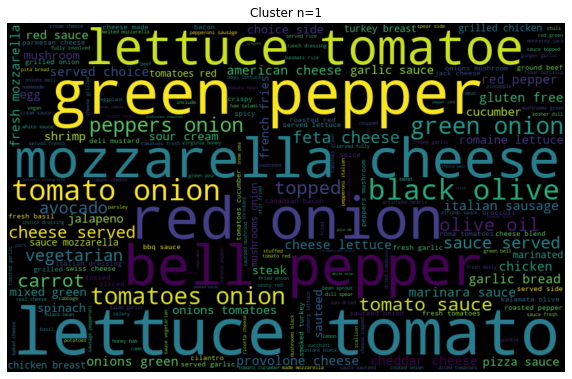

In [24]:
for i in range(6):
    word_cloud(cluster_df,i)
    break

In [27]:
df3 = pd.merge(df_raw,cluster_df,on='Description',how='left')

In [28]:
# df_raw.isna().sum(), df3.isna().sum(),cluster_df.isna().sum()

In [43]:
df4 = df3.groupby(['cluster','Price','Restaurant']).corpus.count().reset_index().drop('corpus',axis=1)
df5 = df4.groupby(['cluster','Price'])['Restaurant'].apply(list).reset_index()
df5['len'] = df5['Restaurant'].apply(lambda x: len(set(x)))
df6 = df5[df5['len']>1][['cluster', 'Price', 'Restaurant']].reset_index(drop=True)
df6['cluster'] = df6['cluster'].astype(int)

In [44]:
df6.shape

(1883, 3)

In [45]:
df6.to_csv('part2_similiar_item.csv', index=False,header=True)

                                                   # End Part2